In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

## Part A

In [2]:
spark = SparkSession.builder.master('local').appName('SOU').getOrCreate()
speeches = spark.read.json('/project/cmsc25025/sou/speeches.json')

# Split speech up by periods and put them into a list of lists [president, year, text]

speech = speeches.rdd.map(lambda x: (x['president'], int(x['year']), x['text'].split('.'))).collect()
# Example of one of the speeches
# President:
print "President:", speech[0][0]
print 
# Year:
print "Year:", speech[0][1]
print 
# First Sentence:
print "First sentence:"
print speech[0][2][0]

# Second Sentence:
print "Second sentence:"
print speech[0][2][1]

President: James Monroe

Year: 1821

First sentence:
 Fellow-Citizens of the Senate and House of Representatives:

 

The progress of our affairs since the last session has been such as may justly be claimed and expected under a Government deriving all its powers from an enlightened people, and under laws formed by their representatives, on great consideration, for the sole purpose of promoting the welfare and happiness of their constituents
Second sentence:
 In the execution of those laws and of the powers vested by the Constitution in the Executive, unremitted attention has been paid to the great objects to which they extend


## Part B

In [3]:
def find_num_sentences(x):
    return int(len(x))
def find_mean_sentence_length(x):
    return float(np.average([len(k.split(' ')) for k in x]))

In [4]:
speech = speeches.rdd.map(lambda x: [[int(x['year']), \
                                      find_num_sentences(x['text'].split('.')), \
                                      find_mean_sentence_length(x['text'].split('.'))]]).reduce(lambda a, b: a + b)
speech = np.array(speech)

In [6]:
# Running Linear Regression
X1 = np.c_[np.array(speech[:,0]), np.ones(len(speech[:,0]))]
Y1 = np.array(speech[:,1])
X2 = np.c_[np.array(speech[:,0]), np.ones(len(speech[:,0]))]
Y2 = np.array(speech[:,2])

left1 = np.dot(X1.transpose(), X1)
right1 = np.dot(X1.transpose(), Y1)
left2 = np.dot(X2.transpose(), X2)
right2 = np.dot(X2.transpose(), Y2)

betas1 = np.linalg.solve(left1, right1.transpose())
betas2 = np.linalg.solve(left2, right2.transpose())

/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


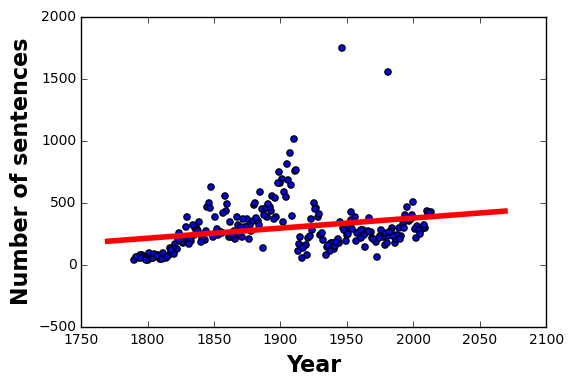

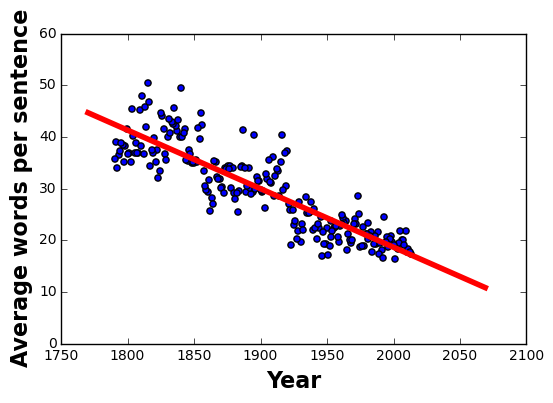

In [7]:
times1 = [i+ 1770 for i in range(300)]
num_sentences = np.dot(betas1[0], times1) + betas1[1]
times2 = [i+ 1770 for i in range(300)]
average_sentence_length = np.dot(betas2[0], times2) + betas2[1]

plt.plot(times1,num_sentences, lw=4, c='red')
plt.scatter(speech[:,0], speech[:,1])
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Number of sentences', fontsize=16, fontweight='bold')
plt.figure()
plt.plot(times2, average_sentence_length, lw=4, c='red')
plt.scatter(speech[:,0], speech[:,2])
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Average words per sentence', fontsize=16, fontweight='bold')

## Part C

In [8]:
def find_total_number_words(x):
    return int(len(x))

In [9]:
speeches1790to1912 = speeches.filter(speeches['year'] <= 1912)
speeches1913toPresent = speeches.filter(speeches['year'] > 1912)

Data1790to1912 = speeches1790to1912.rdd.map(lambda x: [[int(x['year']), \
                                      find_total_number_words(x['text'].split(' '))]]).reduce(lambda a, b: a + b)
Data1913toPresent = speeches1913toPresent.rdd.map(lambda x: [[int(x['year']), \
                                      find_total_number_words(x['text'].split(' '))]]).reduce(lambda a, b: a + b)

Data1790to1912 = np.array(Data1790to1912)
Data1913toPresent = np.array(Data1913toPresent)


In [10]:
# Running Linear Regression
X1 = np.c_[np.array(Data1790to1912[:,0]), np.ones(len(Data1790to1912[:,0]))]
Y1 = np.array(Data1790to1912[:,1])
X2 = np.c_[np.array(Data1913toPresent[:,0]), np.ones(len(Data1913toPresent[:,0]))]
Y2 = np.array(Data1913toPresent[:,1])

left1 = np.dot(X1.transpose(), X1)
right1 = np.dot(X1.transpose(), Y1)
left2 = np.dot(X2.transpose(), X2)
right2 = np.dot(X2.transpose(), Y2)

betas1 = np.linalg.solve(left1, right1.transpose())
betas2 = np.linalg.solve(left2, right2.transpose())

(0, 40000)

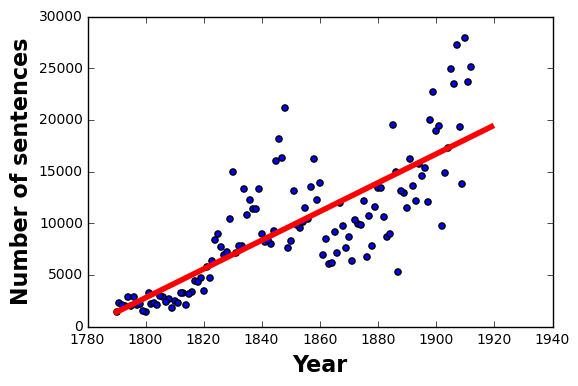

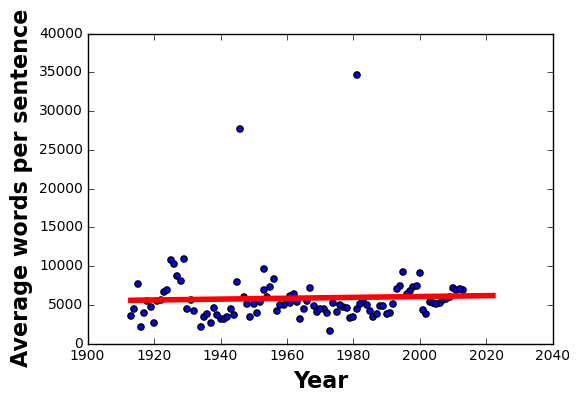

In [11]:
times1 = [i+ 1790 for i in range(130)]
From1790to1912 = np.dot(betas1[0], times1) + betas1[1]
times2 = [i+ 1913 for i in range(110)]
From1913toPresent = np.dot(betas2[0], times2) + betas2[1]

plt.plot(times1, From1790to1912, lw=4, c='red')
plt.scatter(Data1790to1912[:,0], Data1790to1912[:,1])
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Number of sentences', fontsize=16, fontweight='bold')
plt.ylim([0,30000])
plt.figure()
plt.plot(times2, From1913toPresent, lw=4, c='red')
plt.scatter(Data1913toPresent[:,0], Data1913toPresent[:,1])
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Average words per sentence', fontsize=16, fontweight='bold')
plt.ylim([0,40000])

## Part D

#### Which President has the longest sentences on average

In [122]:
speech = speeches.rdd.map(lambda x: (x['president'], \
                                      (find_total_number_words(x['text'].split(' ')),\
                                       find_num_sentences(x['text'].split('.'))))).\
                                    reduceByKey(lambda a,b: (a[0] + b[0], a[1] + b[1])).\
                                    mapValues(lambda x:(float(x[0])/float(x[1]))).collect()

In [131]:
print speech

[(u'Andrew Johnson', 32.273809523809526), (u'Martin Van Buren', 41.75069508804449), (u'Franklin D. Roosevelt', 23.076884672990513), (u'Calvin Coolidge', 21.12124948623099), (u'James Monroe', 34.16965742251224), (u'Zachary Taylor', 34.054054054054056), (u'Millard Fillmore', 34.29637760702525), (u'Warren G. Harding', 25.45124716553288), (u'Theodore Roosevelt', 30.149942107294482), (u'George Washington', 36.16431924882629), (u'James Madison', 42.66600397614314), (u'Ronald Reagan', 19.118884797475012), (u'George Bush', 16.69688385269122), (u'Herbert Hoover', 22.751135331516803), (u'Abraham Lincoln', 26.824101068999028), (u'Benjamin Harrison', 30.020544142143255), (u'Harry S Truman', 17.863722057635336), (u'John Quincy Adams', 40.60978835978836), (u'Thomas Jefferson', 37.07233273056058), (u'Chester A. Arthur', 26.998700454840804), (u'Rutherford B. Hayes', 30.665490472829923), (u'James Buchanan', 29.659247482776895), (u'Gerald R. Ford', 18.899725274725274), (u'John F. Kennedy', 23.1901504787

In [148]:
prrs,cnr=zip(*speech)


In [155]:
print prrs
print np.median(np.array(cnr))

(u'Andrew Johnson', u'Martin Van Buren', u'Franklin D. Roosevelt', u'Calvin Coolidge', u'James Monroe', u'Zachary Taylor', u'Millard Fillmore', u'Warren G. Harding', u'Theodore Roosevelt', u'George Washington', u'James Madison', u'Ronald Reagan', u'George Bush', u'Herbert Hoover', u'Abraham Lincoln', u'Benjamin Harrison', u'Harry S Truman', u'John Quincy Adams', u'Thomas Jefferson', u'Chester A. Arthur', u'Rutherford B. Hayes', u'James Buchanan', u'Gerald R. Ford', u'John F. Kennedy', u'Dwight D. Eisenhower', u'William Howard Taft', u'Richard M. Nixon', u'James K. Polk', u'Jimmy Carter', u'Lyndon B. Johnson', u'William J. Clinton', u'John Adams', u'Franklin Pierce', u'Woodrow Wilson', u'William McKinley', u'George W. Bush', u'John Tyler', u'Barack Obama', u'Grover Cleveland', u'Andrew Jackson', u'Ulysses S. Grant')
30.1313958248


In [146]:
print np.asarray(speech[:,1])
print np.asarray(np.asarray(speech[:,1]), dtype=np.float32)
print np.percentile(np.asarray(speech)[:,1], 25)

TypeError: list indices must be integers, not tuple

In [107]:
def most_common(comp1, comp2):
    president1, wcnt1 = comp1
    president2, wcnt2 = comp2
    if wcnt1 < wcnt2:
        return (president1, wcnt1)
    else:
        return (president2, wcnt2)


In [108]:

longest_pres = speech.reduce(most_common)

print longest_pres

(u'George Bush', 16.69688385269122)


In [178]:
speech = speeches.rdd.map(lambda x: (x['text'].split('.')))\
                     .map(lambda x: (x[0], find_total_number_words(x[0].split(' '))))\
                     .reduceByKey(lambda a,b: a)\
                     .sortBy(lambda x: x[1]*-1.).take(20)
print speech[0][0]

GENTLEMEN OF THE CONGRESS:

 

In fulfilling at this time the duty laid upon me by the Constitution of communicating to you from time to time information of the state of the Union and recommending to your consideration such legislative measures as may be judged necessary and expedient, I shall continue the practice, which I hope has been acceptable to you, of leaving to the reports of the several heads of the executive departments the elaboration of the detailed needs of the public service and confine myself to those matters of more general public policy with which it seems necessary and feasible to deal at the present session of the Congress


In [28]:
speech = speeches.rdd.map(lambda x: [[x['president'],\
                                      int(x['year']), \
                                      find_mean_sentence_length(x['text'].split('.'))]]).reduceByKey(lambda a, b: a + b)

In [23]:
print speech

PythonRDD[43] at RDD at PythonRDD.scala:48
